<a href="https://colab.research.google.com/github/capitalterefe/octomachine/blob/main/soundtoimageProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Get the audio data and extract it


In [1]:
!wget https://goo.gl/8hY5ER
!tar xf 8hY5ER

--2020-11-28 12:01:00--  https://goo.gl/8hY5ER
Resolving goo.gl (goo.gl)... 142.250.73.238, 2607:f8b0:4004:82a::200e
Connecting to goo.gl (goo.gl)|142.250.73.238|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://zenodo.org/record/1203745/files/UrbanSound8K.tar.gz [following]
--2020-11-28 12:01:00--  https://zenodo.org/record/1203745/files/UrbanSound8K.tar.gz
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6023741708 (5.6G) [application/octet-stream]
Saving to: ‘8hY5ER’

8hY5ER               13%[=>                  ] 775.62M  11.1MB/s    eta 6m 30s ^C

gzip: stdin: unexpected end of file
tar: Unexpected EOF in archive
tar: Unexpected EOF in archive
tar: Error is not recoverable: exiting now


In [ ]:
!ls UrbanSound8K/audio/fold1/

In [3]:
import IPython
IPython.display.Audio("UrbanSound8K/audio/fold1/197073-3-4-3.wav")

In [4]:
!cp UrbanSound8K/audio/fold10/* UrbanSound8K/audio/fold1/

In [6]:
!ls UrbanSound8K/audio/fold1/ | wc -l

1117


In [7]:
labels  = ['air_conditioner','car_horn','children_playing',
           'dog_bark','drilling','engine_idling','gun_shot','jackhammer','siren','street_music']

In [8]:
!mkdir 'UrbanSound8K/spectrogram'


In [9]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram
import librosa
import numpy as np
from pathlib import Path
import librosa.display
import os
def create_fold_spectrograms(fold):
    spectrogram_path = Path('UrbanSound8K/spectrogram/')  
    audio_path = Path('UrbanSound8K/audio/')  
    print(f'Processing fold {fold}')
    os.mkdir(spectrogram_path/fold)
    for audio_file in list(Path(audio_path/f'fold{fold}').glob('*.wav')):
        samples, sample_rate = librosa.load(audio_file)
        fig = plt.figure(figsize=[0.72,0.72])
        ax = fig.add_subplot(111)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        ax.set_frame_on(False)
        filename  = spectrogram_path/fold/Path(audio_file).name.replace('.wav','.png')
        S = librosa.feature.melspectrogram(y=samples, sr=sample_rate)
        librosa.display.specshow(librosa.power_to_db(S, ref=np.max))
        plt.savefig(filename, dpi=400, bbox_inches='tight',pad_inches=0)
        plt.close('all')

In [ ]:
create_fold_spectrograms(str(1))

Processing fold 1


In [145]:
!ls UrbanSound8K/spectrogram/1/40722-8-0-1.png


UrbanSound8K/spectrogram/1/40722-8-0-1.png


In [40]:
!mkdir 'UrbanSound8K/data'

In [50]:

import os
import glob
import shutil
from pathlib import Path  
data_path = Path('UrbanSound8K/data/') 
spectrogram_path = Path('UrbanSound8K/spectrogram/')  
def create_fold_directory(fold):
    png_files =  list(Path(spectrogram_path/fold).glob('*.png'))
    os.mkdir(data_path/fold)
    os.mkdir(data_path/fold/'train')
    os.mkdir(data_path/fold/'valid')
    for label in labels:
        os.mkdir(data_path/fold/'train'/label)
        os.mkdir(data_path/fold/'valid'/label)
     
    for file in png_files:
        label = file.as_posix().split('-')[1]
        shutil.copyfile(file, data_path/fold/'valid'/labels[int(label)]/file.name)   
    for i in range(1, 11):       
        if str(i) == fold:
            continue
        png_files =  list(Path(spectrogram_path/fold).glob('*.png'))
        for file in png_files:
            label = file.as_posix().split('-')[1]
            shutil.copyfile(file, data_path/fold/'train'/labels[int(label)]/file.name)

In [57]:
create_fold_directory(str(1))

In [ ]:
!ls  UrbanSound8K/data/1/train/air_conditioner/


In [59]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from fastai import *
from fastai.vision import (
    ImageList,
    cnn_learner,
    models,
    get_transforms,
    error_rate,
    imagenet_stats,
    ClassificationInterpretation,
    ImageDataBunch

)

In [60]:
!ls UrbanSound8K/audio/

fold1  fold10  fold2


In [141]:
data_directory = Path('UrbanSound8K/data')
# don't use any transformations because it doesn't make sense in the case of a spectrogram
# i.e. flipping a spectrogram changes the meaning
data = ImageDataBunch.from_folder(data_directory/'1', ds_tfms=[], size=224)
data.normalize(imagenet_stats)


ImageDataBunch;

Train: LabelList (1710 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
children_playing,children_playing,children_playing,children_playing,children_playing
Path: UrbanSound8K/data/1;

Valid: LabelList (1710 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
children_playing,children_playing,children_playing,children_playing,children_playing
Path: UrbanSound8K/data/1;

Test: None

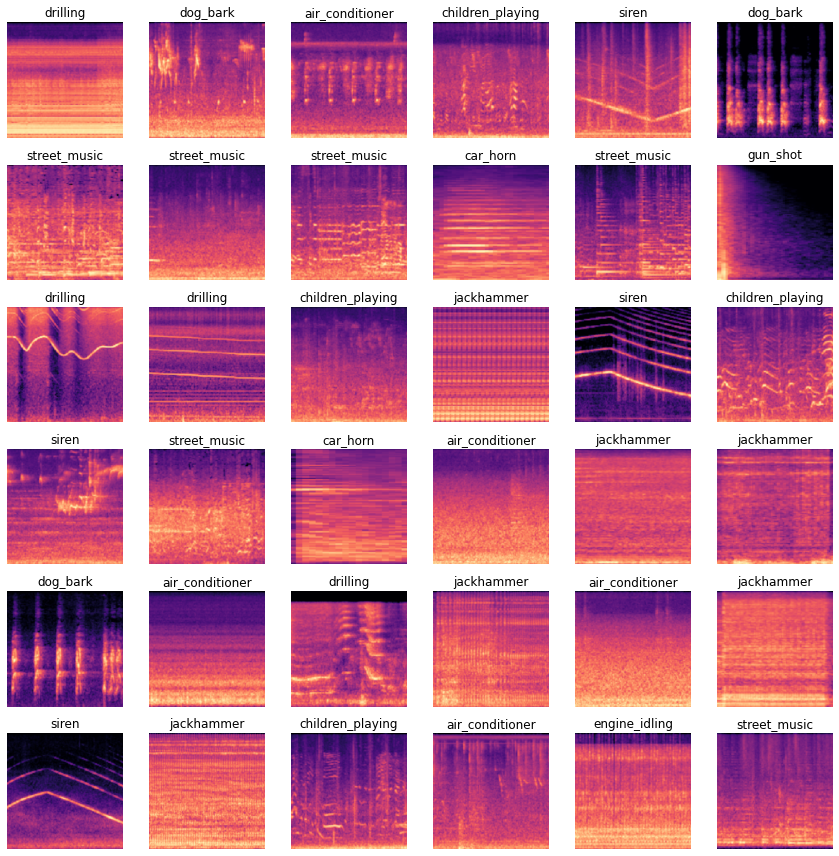

In [63]:
data.show_batch(rows=6, figsize=(12,12))

In [94]:
    data_directory = Path('UrbanSound8K/data')
    data = ImageDataBunch.from_folder(data_directory/'1', ds_tfms=[], size=224)
    data.normalize(imagenet_stats)
    learn = cnn_learner(data, models.resnet34, metrics=error_rate)
    learn.fit_one_cycle(3)
    learn.unfreeze()
    learn.fit_one_cycle(1)
    learn.fit_one_cycle(3, max_lr=slice(1e-6,1e-4))
    

In [95]:
interpretation=ClassificationInterpretation.from_learner(learn)

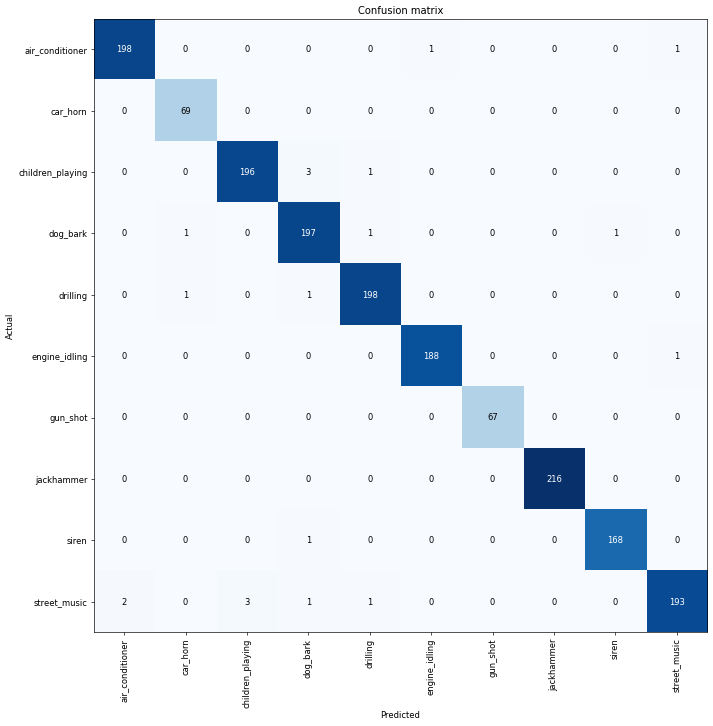

In [96]:
interpretation.plot_confusion_matrix(figsize=(12,12),dpi=60)

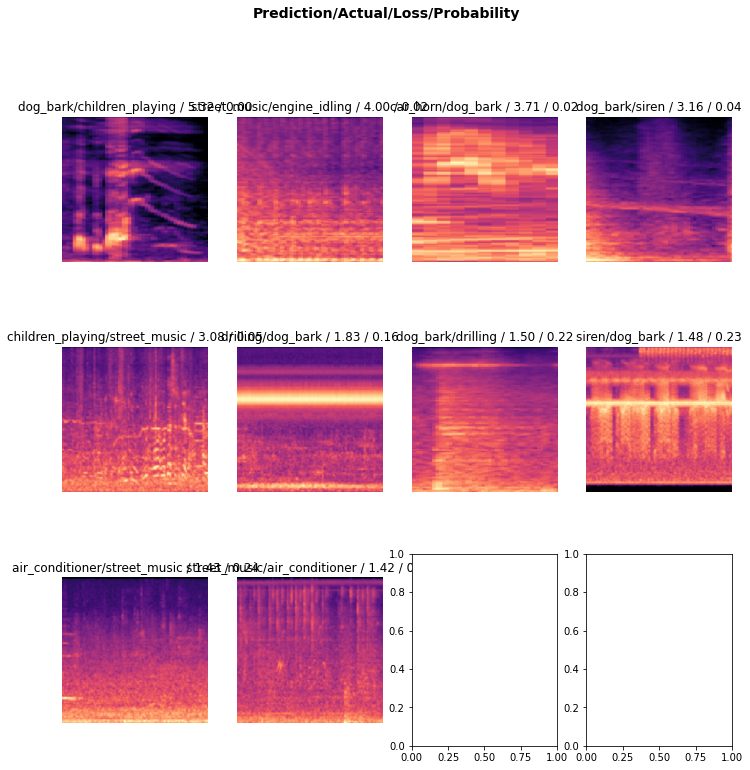

In [97]:
interpretation.plot_top_losses(10, figsize=(12,12))

In [130]:
data.valid_ds

LabelList (1710 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
children_playing,children_playing,children_playing,children_playing,children_playing
Path: UrbanSound8K/data/1

In [ ]:
learn.predict(data.valid_ds[189][0])

In [ ]:
fastai.img

In [ ]:
data.classes

In [138]:
learn.path

PosixPath('UrbanSound8K/data/1')

In [ ]:
learn.export('soundclassifier.plk')

In [147]:
import fastai.vision as fa
learn.predict(fa.image.open_image("UrbanSound8K/spectrogram/1/40722-8-0-1.png"))

(Category tensor(8),
 tensor(8),
 tensor([4.3968e-09, 4.6422e-10, 5.4212e-07, 2.6180e-06, 1.2473e-07, 6.3036e-08,
         1.7560e-07, 4.4850e-10, 1.0000e+00, 4.5400e-08]))